# Kaggle Zillow Preprocessing v3

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')

from sami_function import missing_ratio

%matplotlib inline

In [2]:
df_train = pd.read_csv('../data/train_2016_v2.csv')
prop = pd.read_csv('../data/properties_2016.csv')
sample = pd.read_csv('../data/sample_submission.csv')

print(df_train.shape)
print(prop.shape)

df_train = pd.merge(df_train, prop, on='parcelid', how='left')
print(df_train.shape)

sample.rename(index=str, columns={'ParcelId': 'parcelid'}, inplace=True)
df_test = sample.merge(prop, on='parcelid', how='left')
print(df_test.shape)

print(set(list(df_train.columns)) - set(list(df_test.columns)))
print(set(list(df_test.columns)) - set(list(df_train.columns)))

C:\Users\WBirmingham\AppData\Local\Continuum\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(90275, 3)
(2985217, 58)
(90275, 60)
(2985217, 64)
{'transactiondate', 'logerror'}
{'201610', '201712', '201611', '201612', '201711', '201710'}


In [3]:
from zillow_functions import create_newFeatures, data_preprocessing, memory_reduce

In [5]:
df_train = data_preprocessing(df_train)


	Outliers treated ...


In [8]:
df_train = create_newFeatures(df_train)

In [9]:
df_train = memory_reduce(df_train)

	Initial size 42.96 MB
	There are 0 columns that cannot be reduced
	There are 78 columns reduced
	Final size 14.72 MB


In [8]:
missing_ratio(df_train, n=100, plot=False)

,Missing Ratio


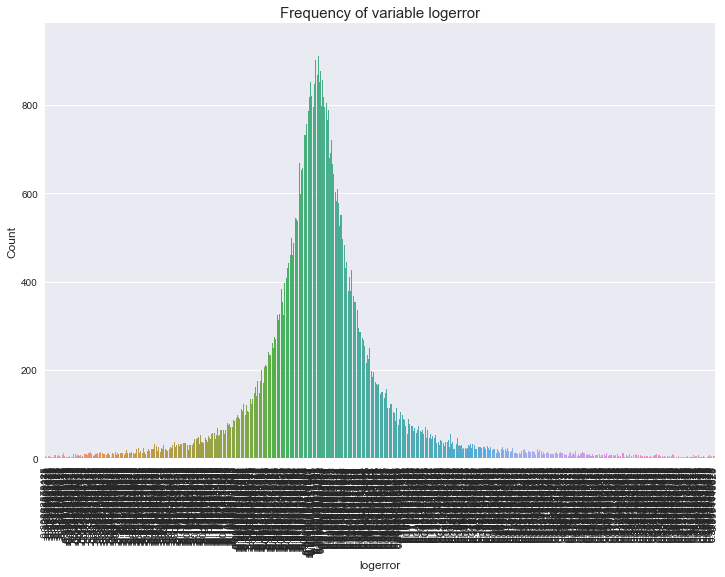

In [96]:
plt.figure(figsize=(12,8))
sns.countplot(x="logerror", data=df_train)
plt.ylabel('Count', fontsize=12)
plt.xlabel('logerror', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of variable logerror", fontsize=15)
plt.show()

In [15]:
x_train = df_train.drop(['parcelid', 'logerror'], axis=1)
y_train = df_train['logerror'].values
x_col = list(x_train.columns)

In [16]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
rfe = RFE(lr)
rfe.fit(x_train, y_train)

RFE(estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
  n_features_to_select=None, step=1, verbose=0)

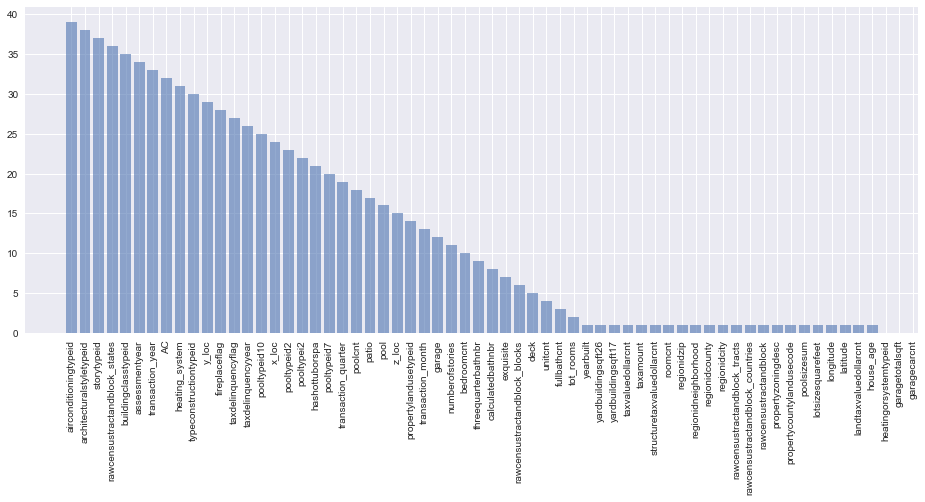

In [17]:
plt.figure(figsize=(16, 6))

y_val = [x[0] for x in [x for x in sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), x_col), reverse=True) if x[0] > 0]]
x_val = [x[1] for x in [x for x in sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), x_col), reverse=True) if x[0] > 0]]

x = np.array(range(len(x_val)))
plt.xticks(x, x_val, rotation=90)
plt.bar(x[:60], y_val[:60], align='center', alpha=0.6)
plt.show()

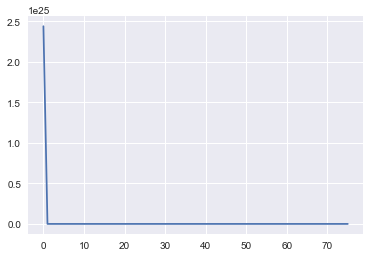

In [13]:
x_train = df_train.drop(['parcelid', 'logerror'], axis=1)
y_train = df_train['logerror'].values

# PCA analysis
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(x_train)

from matplotlib import pyplot as plt
plt.plot(pca.explained_variance_)
plt.show()

ValueError: Unknown label type: 'continuous'

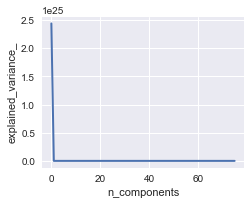

In [14]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import linear_model, decomposition, datasets
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

logistic = linear_model.LogisticRegression()

pca = decomposition.PCA()
pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])

# Plot the PCA spectrum
pca.fit(x_train)

plt.figure(1, figsize=(4, 3))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')

# Prediction
n_components = [20, 40, 64]
Cs = np.logspace(-4, 4, 3)

# Parameters of pipelines can be set using ‘__’ separated parameter names:
estimator = GridSearchCV(pipe,
                         dict(pca__n_components=n_components,
                              logistic__C=Cs))
estimator.fit(x_train, y_train)

plt.axvline(estimator.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', label='n_components chosen')
plt.legend(prop=dict(size=12))
plt.show()

### Create special fearure

In [12]:
from sklearn import linear_model
def creature_special_feature(X, y, model=None):
    if model == None:
        reg = linear_model.LinearRegression()
        reg.fit (X, y)
    else:
        reg = model
    return reg.pred(X), reg

In [13]:
sx_train = x_train[['transaction_year', 'transaction_month', 'transaction_quarter', 'yearbuilt', 'house_age']]
sx_train.head(5)

,transaction_year,transaction_month,transaction_quarter,yearbuilt,house_age
0,2016,1,1,1959,57
1,2016,1,1,2014,2
2,2016,1,1,1940,76
3,2016,1,1,1987,29
4,2016,1,1,1981,35


In [14]:
from sklearn.preprocessing import LabelEncoder

In [15]:
reg = linear_model.LinearRegression()
reg.fit (sx_train, y_train)
pred = reg.predict(sx_train)

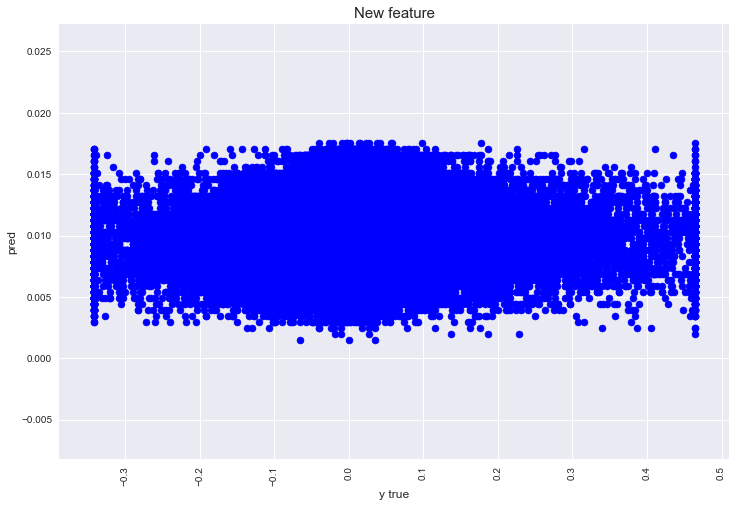

In [16]:
plt.figure(figsize=(12,8))
plt.scatter(y_train, pred, color="blue", linewidth=0.5)
plt.ylabel('pred', fontsize=12)
plt.xlabel('y true', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("New feature", fontsize=15)
plt.show()

In [17]:
from sklearn.preprocessing import StandardScaler

In [18]:
sc = StandardScaler()
sx_train_sc = sc.fit_transform(sx_train)
reg = linear_model.LinearRegression()
reg.fit (sx_train_sc, y_train)
pred_sc = reg.predict(sx_train_sc)

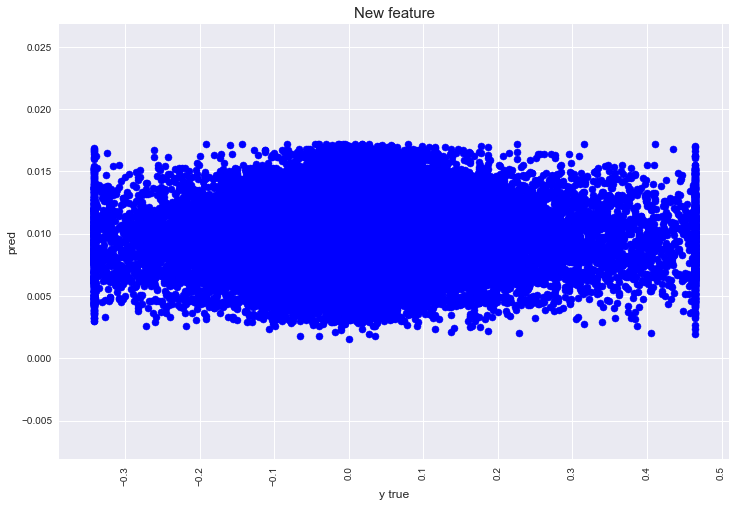

In [19]:
plt.figure(figsize=(12,8))
plt.scatter(y_train, pred_sc, color="blue", linewidth=0.5)
plt.ylabel('pred', fontsize=12)
plt.xlabel('y true', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("New feature", fontsize=15)
plt.show()

#### New model for month treat

In [36]:
month_avgs = df_train.groupby('transaction_month').agg(['mean'])['logerror', 'mean'].values - df_train['logerror'].mean()

from sklearn.linear_model import LinearRegression
month_model = LinearRegression().fit(np.arange(4, 13, 1).reshape(-1, 1), 
                                     month_avgs[3:].reshape(-1, 1))

In [39]:
month_avgs.shape

(12,)

In [32]:
month_values = df_train['transaction_month'].values
X_train = df_train[['transaction_year', 'transaction_month']]
X_train = np.hstack([X_train, month_model.predict(month_values.reshape(-1, 1))])

In [33]:
X_train

array([[  2.01600000e+03,   1.00000000e+00,  -1.03296439e-02],
       [  2.01600000e+03,   1.00000000e+00,  -1.03296439e-02],
       [  2.01600000e+03,   1.00000000e+00,  -1.03296439e-02],
       ..., 
       [  2.01600000e+03,   1.20000000e+01,   8.05918376e-03],
       [  2.01600000e+03,   1.20000000e+01,   8.05918376e-03],
       [  2.01600000e+03,   1.20000000e+01,   8.05918376e-03]])

In [34]:
np.zeros((X_train.shape[0], 1))

array([[ 0.],
       [ 0.],
       [ 0.],
       ..., 
       [ 0.],
       [ 0.],
       [ 0.]])

In [18]:
from sklearn.model_selection import GridSearchCV, KFold

d_train = xgb.DMatrix(x_train, y_train)

param_grid = {
                'eta': [0.01, 0.02, 0.03, 0.04, 0.05, 0.06],
                'max_depth': [6],
                'subsample': [0.80],
                'objective': ['reg:linear'],
                'eval_metric': ['mae'],
                'base_score': [y_mean],
                'silent': [1],
                'seed': [seed]
                }

grid_clf = GridSearchCV(xgb.XGBRegressor, param_grid, 
                        cv=KFold(n_splits=10, random_state=None, shuffle=True),
                        error_score='mae',  verbose=2, refit=True)

grid_clf.fit(x_train, y_train)

print(sorted(grid_clf.cv_results_))
print('\nBest estim : ')
print(grid_clf.best_estimator_)

NameError: name 'xgb' is not defined